In [7]:
gpu_id = 1
train_date = '6.14'
critic_type = 'i'
bs = 8

In [2]:
%reload_ext autoreload
%autoreload 2

# Test

In [8]:


import sys
sys.path.append('../../../model')
sys.path.append('../../../data')
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *
from torchvision import transforms
from load import get_data, get_patched_data, subsample
from utils import custom_cutout
from metrics import psnr, ssim
import losses
from clr import *
import skimage
from skimage.measure import compare_psnr, compare_ssim
from PIL import Image
from libtiff import TIFF


# Basic Setup
torch.cuda.set_device(gpu_id)
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_pth = data_pth/f'EM/models/'

# Resnet Feature loss

size = 512
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]

def inpaint_data(bs, size):
    random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                           min_length=15, max_length=25, use_on_y=False)
    tfms = [[random_patch()], [random_patch()]]
    data = get_patched_data(data_pth, hr_path, bs, tfms=tfms,
                            in_sz=size, out_sz=size)
    return data

def clr_data(bs, size):
    random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=5, max_length=10, use_on_y=False)
    patch_tfms = [random_patch()]
    # Create databunch
    data = get_clr_data(data_pth, hr_dir=hr_path, bs=bs, xtra_tfms=patch_tfms,
                        in_sz=size, out_sz=size)
    return data

def pssr_data(bs, size):
    return get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
            bs=bs, in_sz=size, out_sz=size, max_zoom=2.)

base_model = 'self_sv/baseline/emsynth_005_unet.5'
critic_dict = {
    'i': ['self_sv/inpainting/6.12_critic_50-60_best', inpaint_data],
    's': [base_model, pssr_data]
}

if critic_type=='c':
    critic_data = clr_data(bs, size)
    critic = get_clr_learner(gpu_id, critic_data, model_pth)
    gc.collect()
    critic_model = 'self_sv/contrastive/critic-clr.4b'
    critic.load(critic_model)
    encoder = critic.model.encoder.eval().cuda()
else:
    critic_model, _critic_data = critic_dict[critic_type]
    critic_data = _critic_data(bs, size)
    critic_arch = models.resnet34
    critic = unet_learner(critic_data, critic_arch, wd=wd,
                             loss_func=F.mse_loss,
                             metrics=superres_metrics,
                             blur=True,
                             norm_type=NormType.Weight,
                             model_dir=model_pth)
    gc.collect()
    critic.load(critic_model)
    encoder = critic.model.eval().cuda()[0]

print(f'Critic loaded: {critic_model}')

feature_maps = losses.find_layers(flatten_model(encoder))
num_layers = len(feature_maps)
feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/num_layers for _ in range(num_layers)])

# PSSR Loading

# Training
arch = models.resnet34
wd = 1e-3

learn_model, _learn_data = critic_dict['s']
learn_data = _learn_data(bs, size)
learn = unet_learner(learn_data, arch, wd=wd,
                                 loss_func=feat_loss,
                                 metrics=superres_metrics,
                                 blur=True,
                                 norm_type=NormType.Weight,
                                 model_dir=model_pth)
learn.load(learn_model)

learn.model_dir = model_pth/'self_sv/pssr_based'

lr = 1e-3

def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'Model saved: {save_name}')
#     num_rows = min(learn.data.batch_size, 3)
#     learn.show_results(rows=num_rows, imgsize=5)

critic_names = {
    'c': 'contrastive',
    'i': 'inpaint',
    's': 'self-critic'
}

save_name = train_date + '_' + critic_names[critic_type]

# do_fit(f'{save_name}.1a', lr, cycle_len=3)
# learn.unfreeze()
# do_fit(f'{save_name}.1b', slice(1e-5,lr/10), cycle_len=3)

model_name = f'{save_name}.1b'
learn.load(model_name)

Critic loaded: self_sv/inpainting/6.12_critic_50-60_best


Learner(data=ImageDataBunch;

Train: LabelList (79998 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Valid: LabelList (19999 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel

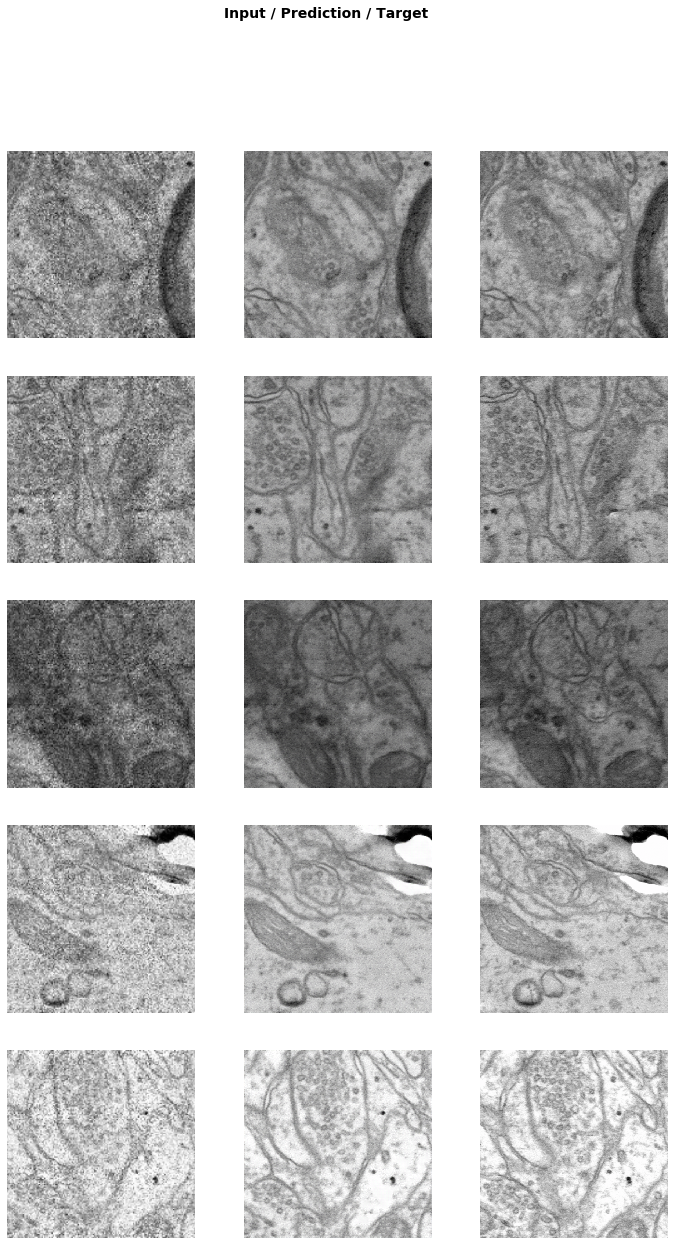

In [9]:
learn.show_results()

In [10]:
# Inference
test_datasets = ['FRC', 'real-world_SEM']

data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_path = data_pth/f'EM/models/self_sv/pssr_based'
infer_pth = data_pth/f'EM/testing/self_sv/pssr_based'


def get_learner(test_data):
    test_pth = data_pth/f'EM/testing/LR/{test_data}'
    test_set = ImageList.from_folder(test_pth, convert_mode='L')
    size = Image.open(list(test_pth.rglob('*.tif'))[0]).size[0]*4
    data = get_data(data_pth, lr_dir, hr_dir, bs=8, 
                in_sz=size, out_sz=size, max_zoom=1.)
    learn = unet_learner(data, arch, wd=wd, 
                     loss_func=feat_loss,
                     metrics=superres_metrics,
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
    gc.collect()
    learn.data.add_test(test_set, tfm_y=False)
    return learn

def model_inference(learner, folder_name=Path("CHANGEME/real-world_SEM"), img_tag=f"CHANGEME"):
    dir_name = infer_pth/folder_name
    if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
    for img, img_name in zip(learner.data.test_ds, learner.data.test_ds.items):
        pred = learner.predict(img[0])
        pred_name = dir_name/img_name.name.replace('lr', img_tag)
        pred_img = pred[1][0]
        tiff = TIFF.open(pred_name, mode='w')
        tiff.write_image(pred_img)

def evaluate_model(pred_files, hr_files):
    psnr_scores = {}
    ssim_scores = {}
    for pred_fname, targ_fname in zip(pred_files, hr_files):
        pred_img = PIL.Image.open(pred_fname)
        targ_img = PIL.Image.open(targ_fname)
        
        pred = skimage.util.img_as_ubyte(np.asarray(pred_img))
        targ = skimage.util.img_as_ubyte(np.asarray(targ_img))
        
        psnr_score = compare_psnr(targ, pred, data_range=255.)
        psnr_scores[targ_fname] = psnr_score
        
        ssim_score = compare_ssim(targ, pred, data_range=255.)
        ssim_scores[targ_fname] = ssim_score
    return psnr_scores, ssim_scores

img_tag = critic_names[critic_type]
for test_data in test_datasets:
    learn = get_learner(test_data)
    target_dirname = data_pth/f'EM/testing/HR/{test_data}/'       # target images
    target_files = sorted(list(target_dirname.rglob('*.tif')))
    print(test_data)
    print('Processing '+str(len(target_files))+' files...')
    results = {}
    mean_psnr = "mean psnr"
    mean_ssim = "mean ssim"
    model_inference(learner=learn, folder_name=Path(f"{model_name}/{test_data}"), img_tag=img_tag)
    inference_dirname = infer_pth/f'{model_name}/{test_data}/'  
    inference_files = sorted(list(inference_dirname.glob('*.tif')))
    results[img_tag] = {}
    results[img_tag]['psnr'], results[img_tag]['ssim'] = evaluate_model(inference_files, target_files)
    results[img_tag]['mean psnr'] = np.mean([results[img_tag]['psnr'][f] for f in results[img_tag]['psnr'].keys()])
    results[img_tag]['mean ssim'] = np.mean([results[img_tag]['ssim'][f] for f in results[img_tag]['ssim'].keys()])
    print(f'{img_tag} \n \t Mean PSNR: {results[img_tag][mean_psnr]:.3f} \n \t Mean SSIM: {results[img_tag][mean_ssim]:.3f}\n')

FRC
Processing 32 files...


/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


inpaint 
 	 Mean PSNR: 13.377 
 	 Mean SSIM: 0.094

real-world_SEM
Processing 42 files...


/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


inpaint 
 	 Mean PSNR: 14.282 
 	 Mean SSIM: 0.121



# Dev

In [3]:
import sys
sys.path.append('../../../model')
sys.path.append('../../../data')
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from load import get_data, get_patched_data, subsample
from utils import custom_cutout
from metrics import psnr, ssim
import losses
from clr import *

In [4]:
# Basic Setup
torch.cuda.set_device(gpu_id)
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_pth = data_pth/f'EM/models/'

# Resnet Feature loss

In [5]:
bs = 8
size = 512
superres_metrics = [F.mse_loss, psnr, ssim]

In [6]:
def inpaint_data(bs, size):
    random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                           min_length=15, max_length=25, use_on_y=False)
    tfms = [[random_patch()], [random_patch()]]
    data = get_patched_data(data_pth, hr_path, bs, tfms=tfms,
                            in_sz=size, out_sz=size)
    return data

def clr_data(bs, size):
    random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=5, max_length=10, use_on_y=False)
    patch_tfms = [random_patch()]
    # Create databunch
    data = get_clr_data(data_pth, hr_dir=hr_path, bs=bs, xtra_tfms=patch_tfms,
                        in_sz=size, out_sz=size)
    return data

def pssr_data(bs, size):
    return get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
            bs=bs, in_sz=size, out_sz=size, max_zoom=2.)

In [7]:
base_model = 'baselines/emsynth_005_unet.5'
critic_dict = {
    'i': ['self_sv/inpainting/critic_inpaint_best', inpaint_data],
    's': [base_model, pssr_data]
}

In [ ]:
if critic_type=='c':
    critic_data = clr_data(bs, size)
    critic = get_clr_learner(gpu_id, critic_data, model_pth)
    gc.collect()
    critic_model = 'self_sv/contrastive/critic-clr.4b'
    critic.load(critic_model)
    encoder = critic.model.encoder.eval().cuda()
else:
    critic_model, _critic_data = critic_dict[critic_type]
    critic_data = _critic_data(bs, size)
    critic_arch = models.resnet34
    wd = 1e-3
    critic = unet_learner(critic_data, critic_arch, wd=wd,
                             loss_func=F.mse_loss,
                             metrics=superres_metrics,
                             blur=True,
                             norm_type=NormType.Weight,
                             model_dir=model_pth)
    gc.collect()
    critic.load(critic_model)
    encoder = critic.model.eval().cuda()[0]

print(f'Critic loaded: {critic_model}')

In [ ]:
feature_maps = losses.find_layers(flatten_model(encoder))
num_layers = len(feature_maps)
feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/num_layers for _ in range(num_layers)])

# PSSR Loading

In [ ]:
# Training
arch = models.resnet34
wd = 1e-3

In [ ]:
learn_model, _learn_data = critic_dict['s']
learn_data = _learn_data(bs, size)
learn = unet_learner(learn_data, arch, wd=wd,
                                 loss_func=feat_loss,
                                 metrics=superres_metrics,
                                 blur=True,
                                 norm_type=NormType.Weight,
                                 model_dir=model_pth)
learn.load(learn_model)

In [ ]:
learn.model_dir = model_pth/'self_sv/pssr_based'

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'Model saved: {save_name}')
#     num_rows = min(learn.data.batch_size, 3)
#     learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
critic_names = {
    'c': 'contrastive',
    'i': 'inpaint',
    's': 'self-critic'
}

In [ ]:
save_name = train_date + '_' + critic_names[critic_type]

In [ ]:
learn.data = subsample(learn.data)

In [ ]:
do_fit(f'{save_name}.1a', lr, cycle_len=3)
learn.unfreeze()
do_fit(f'{save_name}.1b', slice(1e-5,lr/10), cycle_len=3)